In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Iterable

In [2]:
lambda_algo_to_df = {}
algos = ['mgreedy', 'greedymax', '3setenum', '2setenum']
# algos = ['mgreedy', 'greedymax']
experiment_num = "exp7"
augment = False

result_path_tplt = "/home/ctong/Projects/SubOptKnapsack/result/nonmono/{}/nonmono_exp_lambda_{}.csv"
for algo in algos:
    df = pd.read_csv(result_path_tplt.format(experiment_num, algo), header=0, index_col=0)
    df['budget'] = 40.0
    lambda_algo_to_df[algo] = df

In [3]:
budget_algo_to_df = {}
result_path_tplt = "/home/ctong/Projects/SubOptKnapsack/result/nonmono/{}/nonmono_exp_budget_{}.csv"
for algo in algos:
    df = pd.read_csv(result_path_tplt.format(experiment_num, algo), header=0, index_col=0)
    df['llambda'] = 0.75
    budget_algo_to_df[algo] = df

In [4]:
if augment:
    lambda_algo_to_df['3setenum']['f(S)'] *= 1.2
    budget_algo_to_df['3setenum']['f(S)'] *= 1.2
    lambda_algo_to_df['2setenum']['f(S)'] *= 1.1
    budget_algo_to_df['2setenum']['f(S)'] *= 1.1

    scaler = 50 / 15
    for algo in algos:
        for k in ('f(S)', 'Upb'):
            lambda_algo_to_df[algo][k] *= scaler
            budget_algo_to_df[algo][k] *= scaler

In [5]:
# load data
# lambda_algo_to_df['mgreedy'] = pd.read_csv("nonmono_exp_mgreedy.csv", header=0, index_col=0)
# lambda_algo_to_df['greedymax'] = pd.read_csv("nonmono_exp_greedymax.csv", header=0, index_col=0)
# lambda_algo_to_df['mgreedy'] = pd.read_csv("nonmono_exp_mgreedy.csv", header=0, index_col=0)
# lambda_algo_to_df['greedymax'] = pd.read_csv("nonmono_exp_greedymax.csv", header=0, index_col=0)
# lambda_algo_to_df['greedymax']['budget'] = 100.0
# lambda_algo_to_df['mgreedy']['budget'] = 100.0
# budget_algo_to_df['mgreedy'] = pd.read_csv("nonmono_exp_budget_mgreedy.csv", header=0, index_col=0)
# budget_algo_to_df['greedymax'] = pd.read_csv("nonmono_exp_budget_greedymax.csv", header=0, index_col=0)
# budget_algo_to_df['greedymax']['llambda'] = 1
# budget_algo_to_df['mgreedy']['llambda'] = 1


In [6]:
def gen_upb2_af2(df, func):
    """
    Generate upperbound 2 and approximation factor 2.
    Inputs:
    - df: data frame
    - func: approximation factor function from m to af
    """
    df['m'] = 2 * (1 - df['llambda'])
    df['alpha'] = func(df['m'])
    df['Upb2'] = df['f(S)'] / (df['alpha'] + 0.001)
    df['AF2'] = df['f(S)'] / df['Upb2']

def mgreedy_constant_ratio(m):
    beta = 1 - np.exp(-1)
    d = m * beta + m
    c = m * beta + 1
    iota = m + 2 * c * m * m
    h = iota - np.sqrt(iota * iota - 4 * d * m * m)
    return h / 2

def greedymax_constant_ratio(m):
    return m / 2

def three_set_enum(m: Iterable):
    beta = 1 - np.exp(-1)
    return m * m * beta

def two_set_enum(m: Iterable):
    alpha = 1 - np.exp(-1)
    b1 = alpha + 1 - np.sqrt(-5 * alpha * alpha + 2 * alpha + 1)
    b1 = b1 / (2 * alpha)

    b2 = alpha + 1 - np.sqrt(-3 * alpha * alpha + 2 * alpha + 1)
    b2 = b2 / (2 * alpha) 

    h2 = -2 * alpha * m * m + (2 + 2 * alpha) * m - 3 * alpha
    h2_prime = m * (alpha + h2)

    res = np.zeros_like(m)
    for i in range(len(m)):
        if m[i] < b2:
            res[i] = 0
        elif m[i] >= b2 and m[i] < b1:
            res[i] = h2_prime[i]
        else:
            res[i] = alpha * m[i]
    return res

algo_to_m_handler = {
    'mgreedy' : mgreedy_constant_ratio,
    'greedymax' : greedymax_constant_ratio,
    '3setenum' : three_set_enum,
    '2setenum' : two_set_enum,
}

for algo in algos:
    gen_upb2_af2(budget_algo_to_df[algo], algo_to_m_handler[algo])
    gen_upb2_af2(lambda_algo_to_df[algo], algo_to_m_handler[algo])

# gen_upb2_af2(budget_algo_to_df['greedymax'], greedymax_constant_ratio)
# gen_upb2_af2(lambda_algo_to_df['greedymax'], greedymax_constant_ratio)
# gen_upb2_af2(budget_algo_to_df['mgreedy'], mgreedy_constant_ratio)
# gen_upb2_af2(lambda_algo_to_df['mgreedy'], mgreedy_constant_ratio)

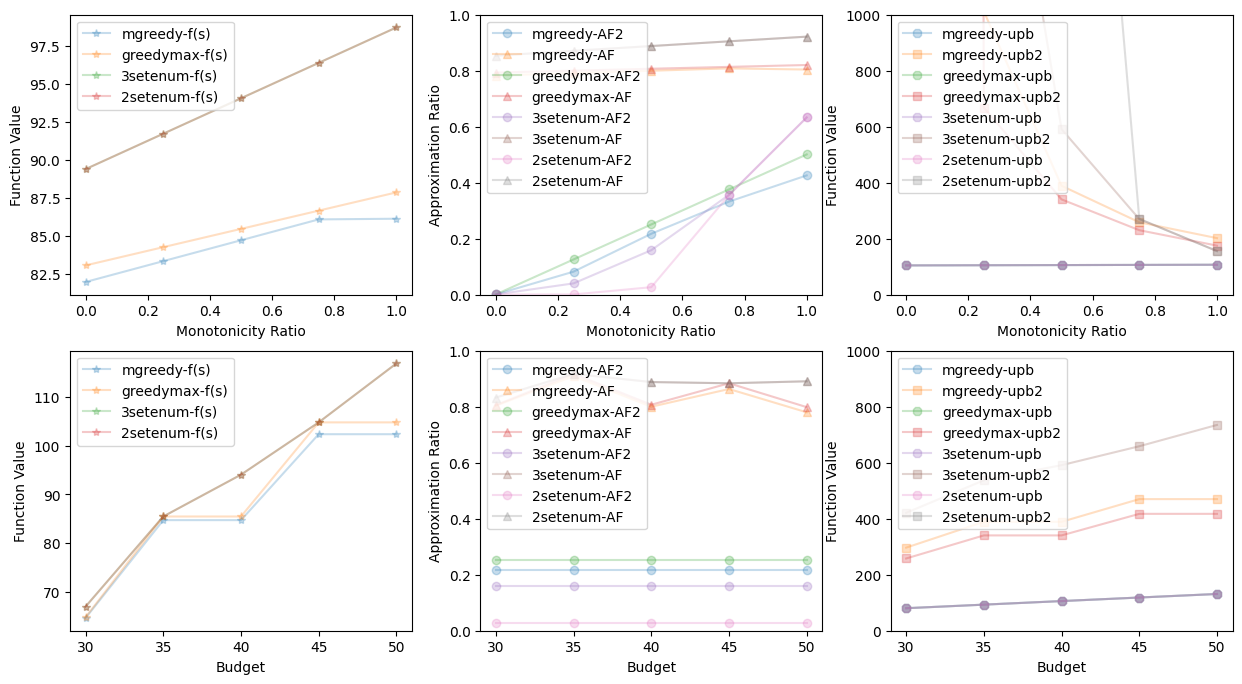

In [7]:
height, width = 4, 5
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(cols * width, rows * height))
overlapping = 0.250
# two rows: lambda and budget 
for i, row_axes in enumerate(axes):
    if i == 0:
        X = 2 * (1 - lambda_algo_to_df['greedymax']['llambda'])
        # df1, df2 = lambda_algo_to_df['mgreedy'], lambda_algo_to_df['greedymax']
        df_dict = lambda_algo_to_df
    else:
        X = budget_algo_to_df['greedymax']['budget']
        df_dict = budget_algo_to_df
        # df1, df2 = budget_algo_to_df['mgreedy'], budget_algo_to_df['greedymax']

    for algo in algos:
        df = df_dict[algo]
        row_axes[0].plot(X, df['f(S)'], label="{}-f(s)".format(algo), marker="*", alpha=overlapping)
        # row_axes[1].plot(X, df['AF'], label="{}-AF".format(algo))
        row_axes[1].plot(X, df['AF2'], label="{}-AF2".format(algo), marker="o", alpha=overlapping)
        row_axes[1].plot(X, df['AF'], label="{}-AF".format(algo), marker="^", alpha=overlapping)
        row_axes[2].plot(X, df['Upb'], label="{}-upb".format(algo), marker="8", alpha=overlapping)
        row_axes[2].plot(X, df['Upb2'], label="{}-upb2".format(algo), marker="s", alpha=overlapping)
        
    # row_axes[0].plot(X, df1['f(S)'], label="MGreedy")
    # row_axes[0].plot(X, df2['f(S)'], label="GreedyMax")
    # row_axes[1].plot(X, df1['AF'], label="MGreedy")
    # row_axes[1].plot(X, df2['AF'], label="GreedyMax")
    # row_axes[1].plot(X, df1['AF2'], label="MGreedy-2")
    # row_axes[1].plot(X, df2['AF2'], label="GreedyMax-2")

    if i == 0:
        row_axes[0].set_xlabel("Monotonicity Ratio")
        row_axes[1].set_xlabel("Monotonicity Ratio")
        row_axes[2].set_xlabel("Monotonicity Ratio")
        # row_axes[3].set_xlabel("Monotonicity Ratio")
    else:
        row_axes[0].set_xlabel("Budget")
        row_axes[1].set_xlabel("Budget")
        row_axes[2].set_xlabel("Budget")
        # row_axes[3].set_xlabel("Budget")
    row_axes[0].set_ylabel("Function Value")
    row_axes[1].set_ylabel("Approximation Ratio")
    row_axes[1].set_ylim(0., 1.)
    row_axes[2].set_ylim(0, 1000)
    # row_axes[3].set_ylim(0, 30)
    row_axes[2].set_ylabel("Function Value")
    # row_axes[3].set_ylabel("Function Value")

    # if i == 0:
    row_axes[0].legend(loc="upper left")
    row_axes[1].legend(loc="upper left")
    row_axes[2].legend(loc="upper left")
        # row_axes[3].legend(loc="upper left")



plt.show()